# Import Libraries

In [52]:
import numpy as np
import pandas as pd
import pickle
import skopt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Load Models

In [53]:
directory = '../data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
with open(directory + 'data_split.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [55]:
def load_results(filename):
    with open(directory + filename, 'rb') as file:
        return pickle.load(file)

In [56]:
multivariate_regression_results = load_results('multivariate_regression_results.pkl')
attention_results = load_results('attention_results.pkl')
catboost_results = load_results('catboost_results.pkl')
lightgbm_results = load_results('lightgbm_results.pkl')
multilayer_perceptron_results = load_results('multilayer_perceptron_results.pkl')
xgboost_results = load_results('xgboost_results.pkl')

In [57]:
multivariate_regression_predict = multivariate_regression_results['y_pred']
attention_predict = attention_results['y_pred'].flatten() # Flattened
catboost_predict = catboost_results['y_pred']
lightgbm_predict = lightgbm_results['y_pred']
multilayer_perceptron_predict = multilayer_perceptron_results['y_pred']
xgboost_predict = xgboost_results['y_pred']

In [58]:
multivariate_regression_mse = multivariate_regression_results['mse']
attention_mse = attention_results['mse']
catboost_mse = catboost_results['mse']
lightgbm_mse = lightgbm_results['mse']
multilayer_perceptron_mse = multilayer_perceptron_results['mse']
xgboost_mse = xgboost_results['mse']

print(f"Multivariate Regression MSE: {multivariate_regression_mse}")
print(f"Attention MSE: {attention_mse}")
print(f"CatBoost MSE: {catboost_mse}")
print(f"LightGBM MSE: {lightgbm_mse}")
print(f"Multilayer Perception MSE: {multilayer_perceptron_mse}")
print(f"XGBoost MSE: {xgboost_mse}")

Multivariate Regression MSE: 0.5337646970617783
Attention MSE: 0.656536877155304
CatBoost MSE: 0.17515439996003626
LightGBM MSE: 0.2284191969094807
Multilayer Perception MSE: 0.20686680148159395
XGBoost MSE: 0.14505752909269076


In [59]:
mse_values = np.array([
    multivariate_regression_mse,
    xgboost_mse,
    catboost_mse,
    lightgbm_mse,
    multilayer_perceptron_mse,
    attention_mse
])

weights = 1 / mse_values

normalized_weights = weights / weights.sum()

print("Normalized Weights:", normalized_weights)

Normalized Weights: [0.07431031 0.27343787 0.2264529  0.17364662 0.19173798 0.06041431]


In [60]:
ensemble_pred = (
    normalized_weights[0] * multivariate_regression_predict +
    normalized_weights[1] * xgboost_predict +
    normalized_weights[2] * catboost_predict +
    normalized_weights[3] * lightgbm_predict +
    normalized_weights[4] * multilayer_perceptron_predict +
    normalized_weights[5] * attention_predict
)

**Evaluation**

In [61]:
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print("Ensemble MSE:", ensemble_mse)
print("Ensemble MAE:", ensemble_mae)
print("Ensemble R-squared:", ensemble_r2)

Ensemble MSE: 0.16338620699280104
Ensemble MAE: 0.06401957870818774
Ensemble R-squared: 0.8271905483431852


# Sort By Best MSE

In [62]:
mse_values = {
    "Multivariate Regression": multivariate_regression_mse,
    "Attention": attention_mse,
    "CatBoost": catboost_mse,
    "LightGBM": lightgbm_mse,
    "Multilayer Perception": multilayer_perceptron_mse,
    "XGBoost": xgboost_mse
}

sorted_mse_values = sorted(mse_values.items(), key=lambda item: item[1])

print("Sorted MSE values:")
for model, mse in sorted_mse_values:
    print(f"{model}: MSE = {mse}")

Sorted MSE values:
XGBoost: MSE = 0.14505752909269076
CatBoost: MSE = 0.17515439996003626
Multilayer Perception: MSE = 0.20686680148159395
LightGBM: MSE = 0.2284191969094807
Multivariate Regression: MSE = 0.5337646970617783
Attention: MSE = 0.656536877155304


In [63]:
print("Multivariate Regression")
print("MSE:", multivariate_regression_mse)
print("MAE:", multivariate_regression_results['mae'])
print("R-squared:", multivariate_regression_results['r2'])

print('\n')

print("Attention")
print("MSE:", attention_mse)
print("MAE:", attention_results['mae'])
print("R-squared:", attention_results['r2'])

print('\n')

print("CatBoost")
print("MSE:", catboost_mse)
print("MAE:", catboost_results['mae'])
print("R-squared:", catboost_results['r2'])

print('\n')

print("LightGBM")
print("MSE:", lightgbm_mse)
print("MAE:", lightgbm_results['mae'])
print("R-squared:", lightgbm_results['r2'])

print('\n')

print("Multilayer Perceptron")
print("MSE:", multilayer_perceptron_mse)
print("MAE:", multilayer_perceptron_results['mae'])
print("R-squared:", multilayer_perceptron_results['r2'])


print('\n')

print("XGBoost")
print("MSE:", xgboost_mse)
print("MAE:", xgboost_results['mae'])
print("R-squared:", xgboost_results['r2'])

Multivariate Regression
MSE: 0.5337646970617783
MAE: 0.13429721805635644
R-squared: 0.4354506031401052


Attention
MSE: 0.656536877155304
MAE: 0.3045461177825928
R-squared: 0.3055974032443759


CatBoost
MSE: 0.17515439996003626
MAE: 0.045369651363129725
R-squared: 0.8147436287953858


LightGBM
MSE: 0.2284191969094807
MAE: 0.09534924616511659
R-squared: 0.7584068025549024


Multilayer Perceptron
MSE: 0.20686680148159395
MAE: 0.05768942653518359
R-squared: 0.7812022251571791


XGBoost
MSE: 0.14505752909269076
MAE: 0.05906721399910874
R-squared: 0.8465763265909905


# Optimal Ensemble Model Selection

In [64]:
models = [
    ("Multivariate Regression", multivariate_regression_predict, multivariate_regression_mse),
    ("LightGBM", lightgbm_predict, lightgbm_mse),
    ("XGBoost", xgboost_predict, xgboost_mse),
    ("Multilayer Perception", multilayer_perceptron_predict, multilayer_perceptron_mse),
    ("CatBoost", catboost_predict, catboost_mse),
    ("Attention Mechanism", attention_predict, attention_mse)
]

best_combination = None
best_mse = float('inf')
best_mae = float('inf')
best_r2 = float('-inf')

def compute_ensemble(predictions, weights):
    ensemble_pred = np.zeros_like(predictions[0])
    for pred, weight in zip(predictions, weights):
        ensemble_pred += weight * pred
    return ensemble_pred

for r in range(2, len(models) + 1):  
    for combination in itertools.combinations(models, r):
        model_names, y_preds, mse_vals = zip(*combination)

        weights = 1 / np.array(mse_vals)
        normalized_weights = weights / weights.sum()

        ensemble_pred = compute_ensemble(y_preds, normalized_weights)

        ensemble_mse = mean_squared_error(y_test, ensemble_pred)
        ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
        r2_ensemble = r2_score(y_test, ensemble_pred)

        print(f"Combination: {model_names}")
        print(f"Ensemble MSE: {ensemble_mse}")
        print(f"Ensemble MAE: {ensemble_mae}")
        print(f"Ensemble R-squared: {r2_ensemble}")
        print("-" * 40)

        if ensemble_mse < best_mse:
            best_mse = ensemble_mse
            best_mae = ensemble_mae
            best_r2 = r2_ensemble
            best_combination = model_names

print("Best Combination:", best_combination)
print("Best Ensemble MSE:", best_mse)
print("Best Ensemble MAE:", best_mae)
print("Best Ensemble R-squared:", best_r2)

Combination: ('Multivariate Regression', 'LightGBM')
Ensemble MSE: 0.24783274246709217
Ensemble MAE: 0.09281160070859198
Ensemble R-squared: 0.7378735872714774
----------------------------------------
Combination: ('Multivariate Regression', 'XGBoost')
Ensemble MSE: 0.18104652044567385
Ensemble MAE: 0.07265154284625544
Ensemble R-squared: 0.808511682237842
----------------------------------------
Combination: ('Multivariate Regression', 'Multilayer Perception')
Ensemble MSE: 0.25062293610307046
Ensemble MAE: 0.06962634823949461
Ensemble R-squared: 0.7349224701537944
----------------------------------------
Combination: ('Multivariate Regression', 'CatBoost')
Ensemble MSE: 0.21145201596391347
Ensemble MAE: 0.06487388136056112
Ensemble R-squared: 0.7763525599681621
----------------------------------------
Combination: ('Multivariate Regression', 'Attention Mechanism')
Ensemble MSE: 0.5593791057403202
Ensemble MAE: 0.17963536684987502
Ensemble R-squared: 0.40835889203595166
--------------

# Ensemble Prediction

In [65]:
mse_values = np.array([
    xgboost_mse,
    catboost_mse
])

weights = 1 / mse_values

normalized_weights = weights / weights.sum()

print("Normalized Weights:", normalized_weights)

Normalized Weights: [0.54699524 0.45300476]


In [66]:
ensemble_pred = (
    normalized_weights[0] * xgboost_predict +
    normalized_weights[1] * catboost_predict
)

**Evaluation**

In [67]:
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print("Ensemble MSE:", ensemble_mse)
print("Ensemble MAE:", ensemble_mae)
print("Ensemble R-squared:", ensemble_r2)

Ensemble MSE: 0.12328428142408768
Ensemble MAE: 0.051732446551841074
Ensemble R-squared: 0.8696053390128597


# Results

In [68]:
with open(directory + 'data_split.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [69]:
xgboost_model = xgboost_results['model'].best_estimator_
catboost_model = catboost_results['model'].best_estimator_

assert isinstance(xgboost_model.named_steps['reg'], XGBRegressor), "Expected XGBRegressor, got {}".format(type(xgboost_model.named_steps['reg']))

xgboost_explainer = shap.Explainer(xgboost_model.named_steps['reg'])
catboost_explainer = shap.Explainer(catboost_model.named_steps['reg'])

xgboost_shap_values = xgboost_explainer(X_test)
catboost_shap_values = catboost_explainer(X_test)

xgboost_shap_values_array = xgboost_shap_values.values
catboost_shap_values_array = catboost_shap_values.values

ensemble_shap_values_array = (
    normalized_weights[0] * xgboost_shap_values_array +
    normalized_weights[1] * catboost_shap_values_array
)

ensemble_explanation = shap.Explanation(
    values=ensemble_shap_values_array,
    base_values=np.mean(ensemble_pred),
    data=X_test,
    feature_names=X_test.columns
)

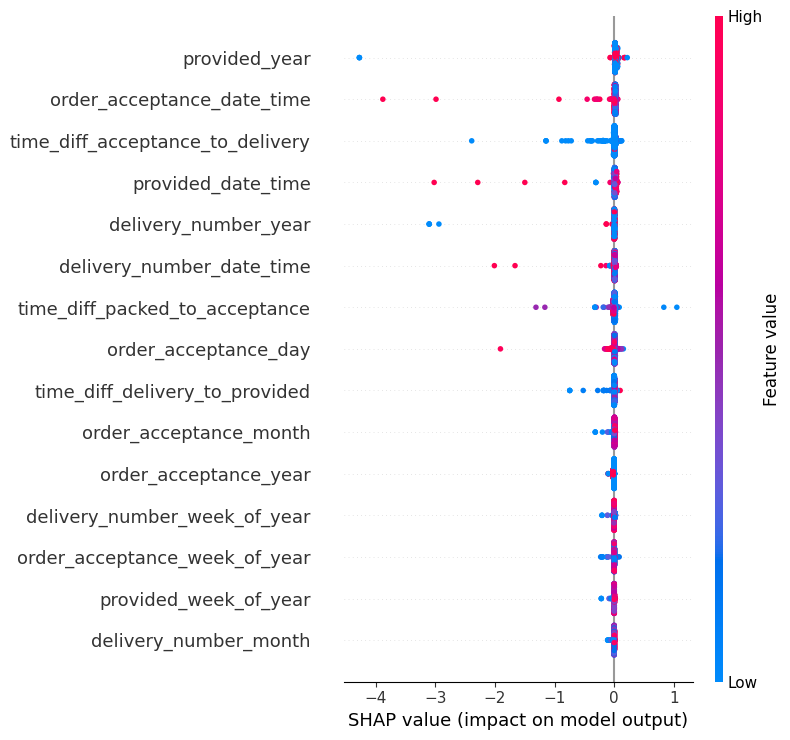

In [70]:
shap.summary_plot(ensemble_explanation, X_test)

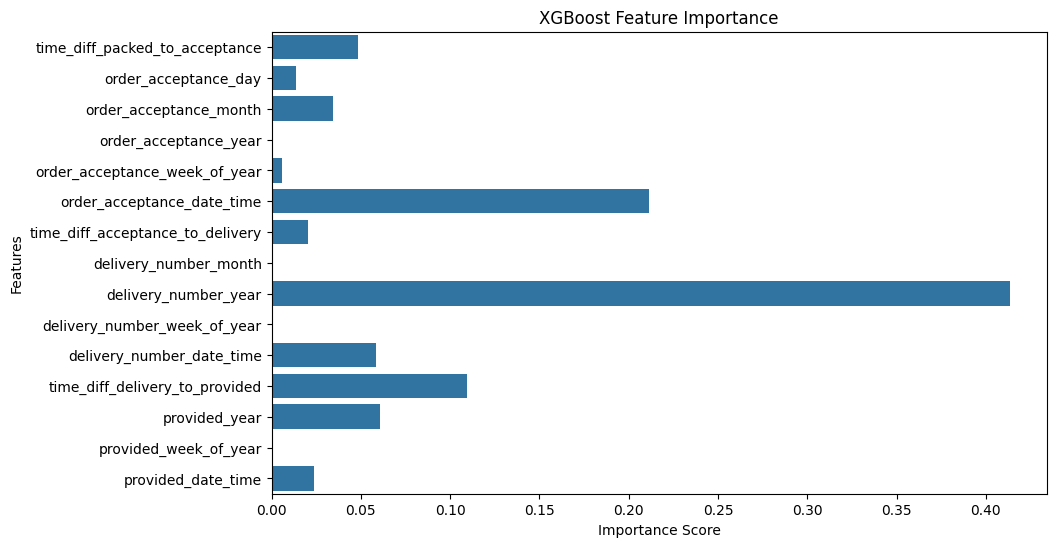

In [76]:
importances_xgboost = xgboost_model.named_steps['reg'].feature_importances_
feature_names = X_test.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_xgboost, y=feature_names)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

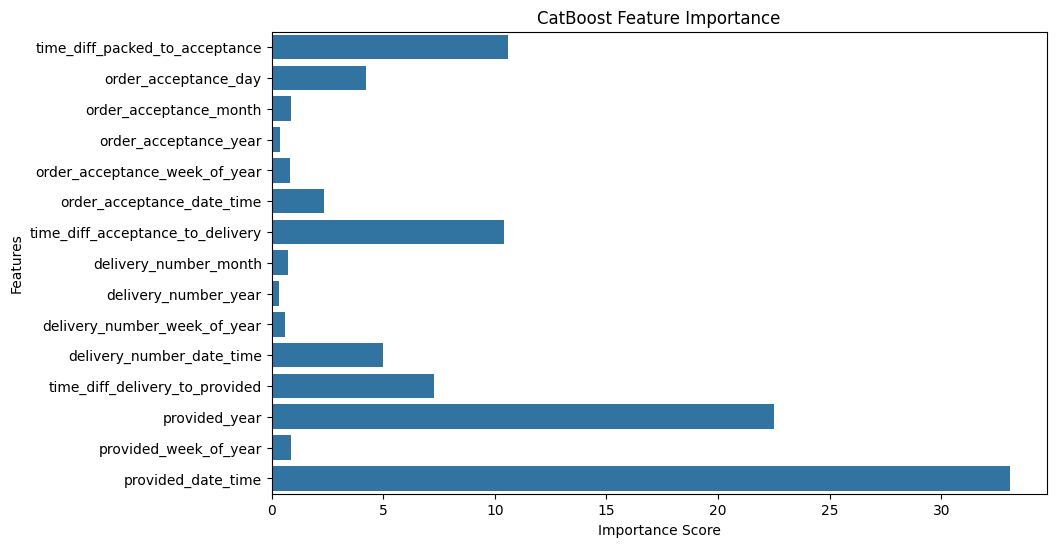

In [72]:
importances_catboost = catboost_model.named_steps['reg'].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_catboost, y=feature_names)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

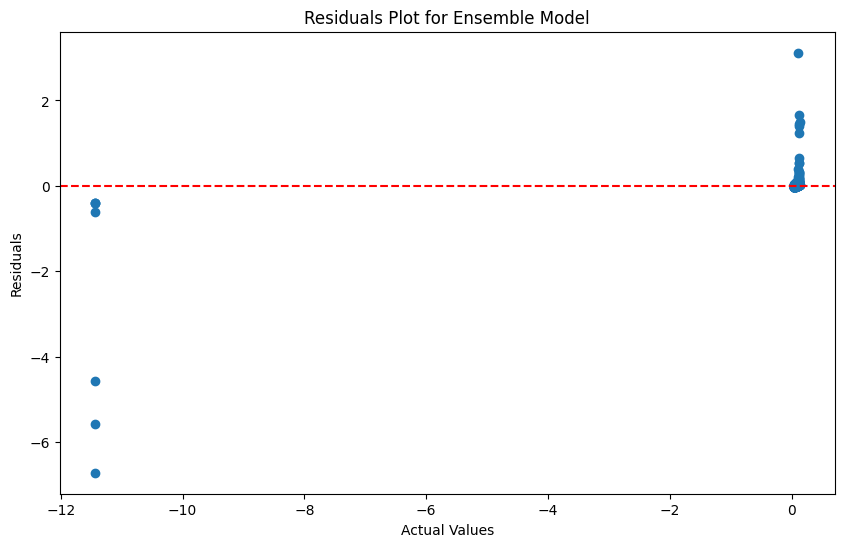

In [73]:
residuals = y_test - ensemble_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.title('Residuals Plot for Ensemble Model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

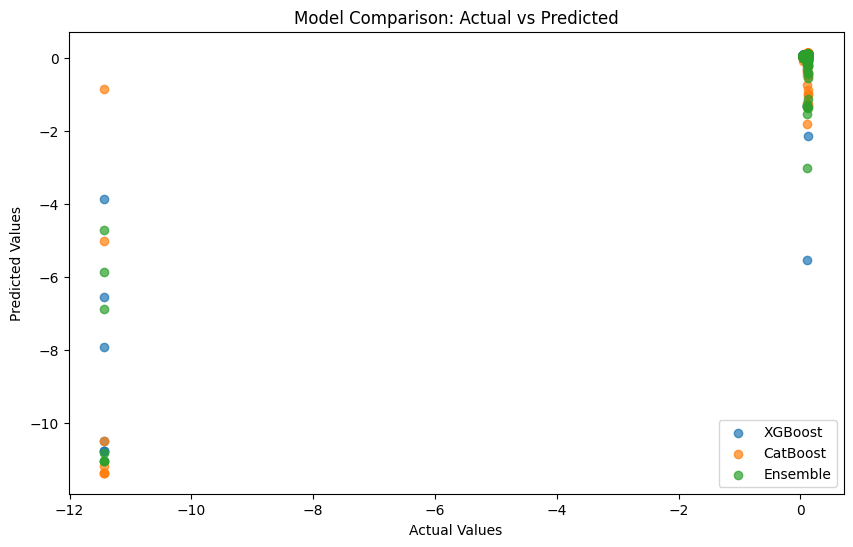

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgboost_predict, label='XGBoost', alpha=0.7)
plt.scatter(y_test, catboost_predict, label='CatBoost', alpha=0.7)
plt.scatter(y_test, ensemble_pred, label='Ensemble', alpha=0.7)
plt.title('Model Comparison: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [75]:
print("Ensemble MSE:", ensemble_mse)
print("Ensemble MAE:", ensemble_mae)
print("Ensemble R-squared:", ensemble_r2)

Ensemble MSE: 0.12328428142408768
Ensemble MAE: 0.051732446551841074
Ensemble R-squared: 0.8696053390128597
